# Wallmart Dataset

Se desea crear un modelo de redes neuronales LSTM, entrenado con Series de Tiempo capaz de predecir la demanda durante un mes de una empresa, tomando como datos de referencia el dataset Walmart Sales Forecast.

## Importe de librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Información basica

### Descripcion del dataset:

* features.csv: Datos adicionales relacionados con la tienda, departamento y actividad regional para las fechas indicadas.

* train.csv: estos son los datos históricos de entrenamiento, que abarcan desde el 5 de febrero de 2010 hasta el 17 de agosto de 2012.

* test.csv: similar a train.csv, necesitamos predecir las ventas semanales.

* store.csv: Contiene información anónima sobre las 45 tiendas, indicando el tipo y tamaño de la tienda.


In [ ]:
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
def info_basica(df):
    print("Dimensiones:", df.shape)
    print("\nColumnas:", df.columns.tolist())
    print("\nNulos por columna:\n", df.isnull().sum())
    print("\nValores únicos por columna:\n", df.nunique())
    print("\nPrimeras 5 filas:\n", df.head())
    print("\nTipos de datos:\n", df.dtypes)

In [ ]:
info_basica(features_df)

Dimensiones: (8190, 12)

Columnas: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']

Nulos por columna:
 Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

Valores únicos por columna:
 Store             45
Date             182
Temperature     4178
Fuel_Price      1011
MarkDown1       4023
MarkDown2       2715
MarkDown3       2885
MarkDown4       3405
MarkDown5       4045
CPI             2505
Unemployment     404
IsHoliday          2
dtype: int64

Primeras 5 filas:
    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2  

In [ ]:
info_basica(stores_df)

Dimensiones: (45, 3)

Columnas: ['Store', 'Type', 'Size']

Nulos por columna:
 Store    0
Type     0
Size     0
dtype: int64

Valores únicos por columna:
 Store    45
Type      3
Size     40
dtype: int64

Primeras 5 filas:
    Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

Tipos de datos:
 Store     int64
Type     object
Size      int64
dtype: object


In [ ]:
info_basica(train_df)

Dimensiones: (421570, 5)

Columnas: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

Nulos por columna:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

Valores únicos por columna:
 Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
dtype: int64

Primeras 5 filas:
    Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Tipos de datos:
 Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object


In [ ]:
info_basica(test_df)

Dimensiones: (115064, 4)

Columnas: ['Store', 'Dept', 'Date', 'IsHoliday']

Nulos por columna:
 Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

Valores únicos por columna:
 Store        45
Dept         81
Date         39
IsHoliday     2
dtype: int64

Primeras 5 filas:
    Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False

Tipos de datos:
 Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object


## Estadistica Descriptiva:

In [ ]:
def graficar_histogramas(df, width=4, height=3):
    variables_numericas = df.select_dtypes(include=np.number).columns
    num_vars = len(variables_numericas)

    # Definir el tamaño de la cuadrícula de subgráficos
    filas = (num_vars // 3) + (num_vars % 3 > 0)
    columnas = 3

    plt.figure(figsize=(width * columnas, height * filas))

    for i, col in enumerate(variables_numericas, 1):
        plt.subplot(filas, columnas, i)
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(col)
        plt.xlabel('')
        plt.ylabel('')

    plt.tight_layout()
    plt.show()


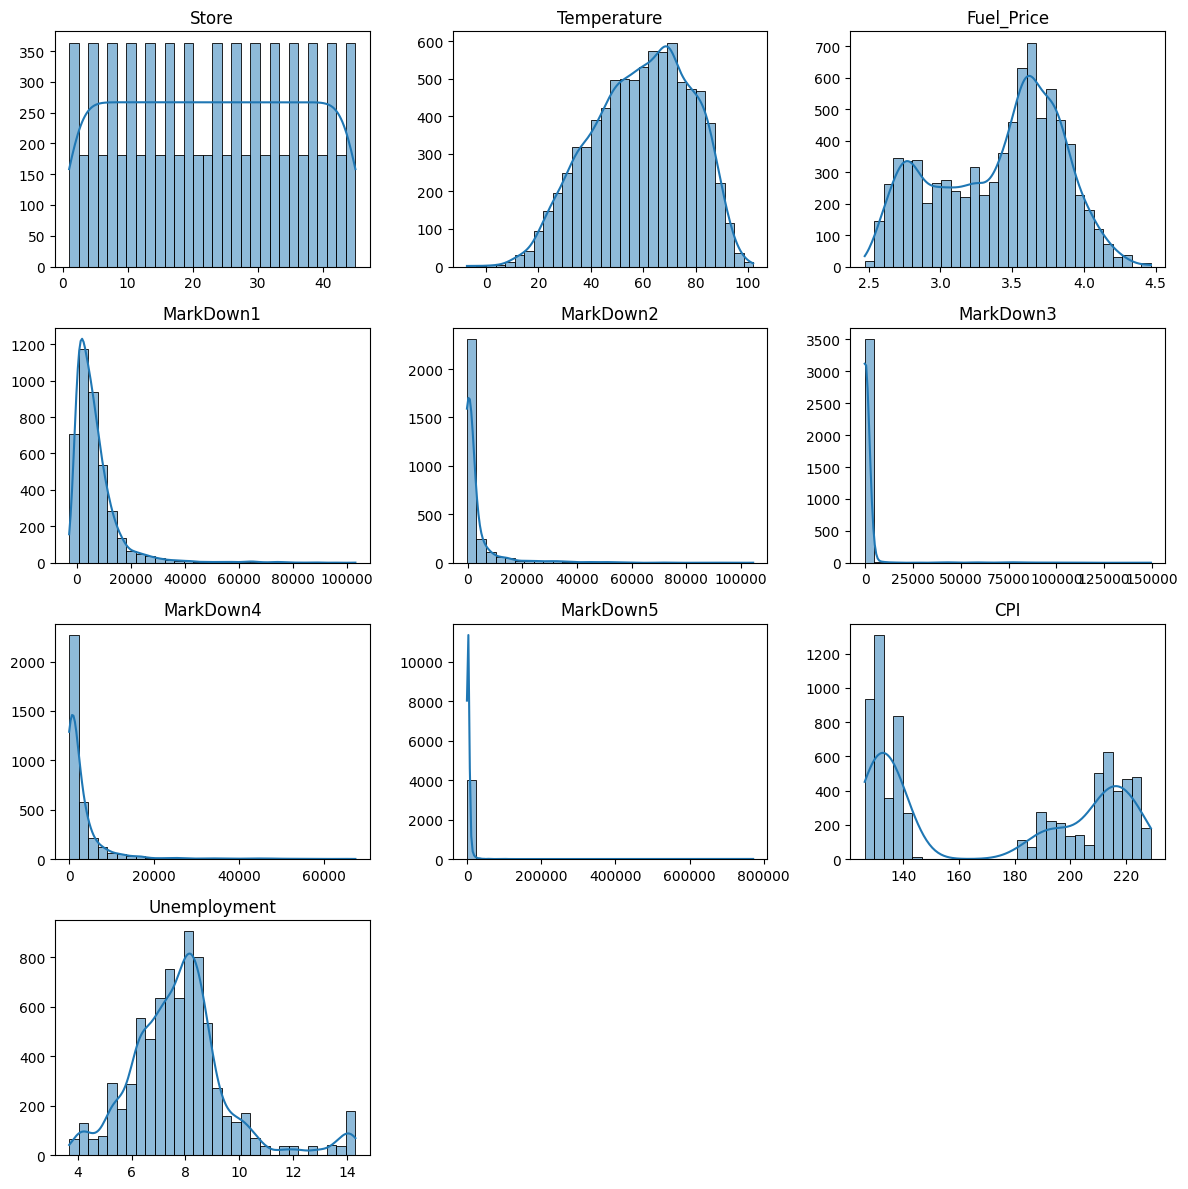

In [ ]:
graficar_histogramas(features_df)

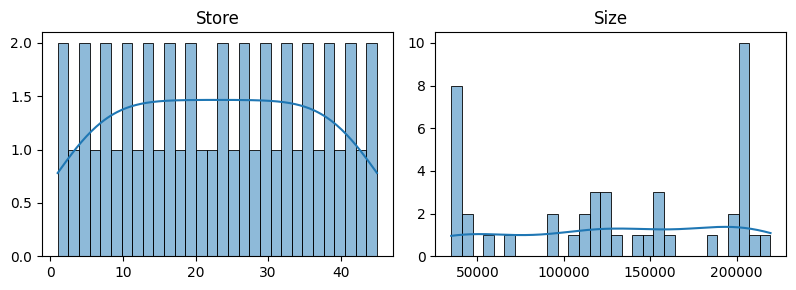

In [ ]:
graficar_histogramas(stores_df)

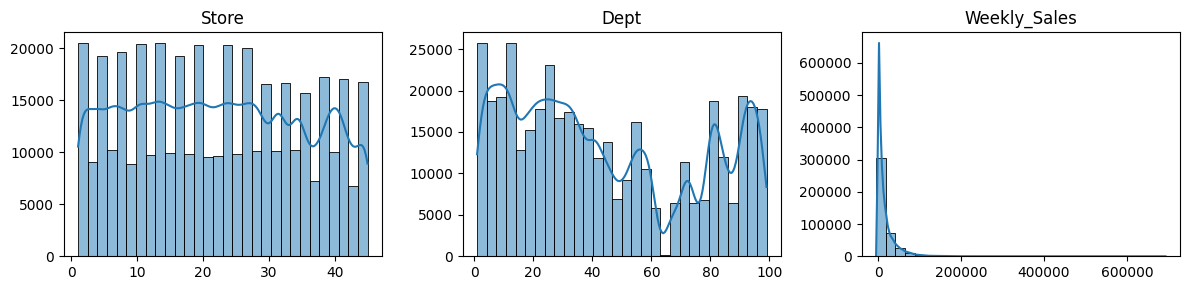

In [ ]:
graficar_histogramas(train_df)

In [ ]:
def graficar_ventas_por_fecha(df):
    # Asegurarse de que la columna 'Date' sea de tipo datetime
    df['Date'] = pd.to_datetime(df['Date'])

    plt.figure(figsize=(14, 6))
    sns.lineplot(x='Date', y='Weekly_Sales', data=df)

    plt.title('Ventas Semanales a lo Largo del Tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Semanales')
    plt.grid(True)
    plt.show()

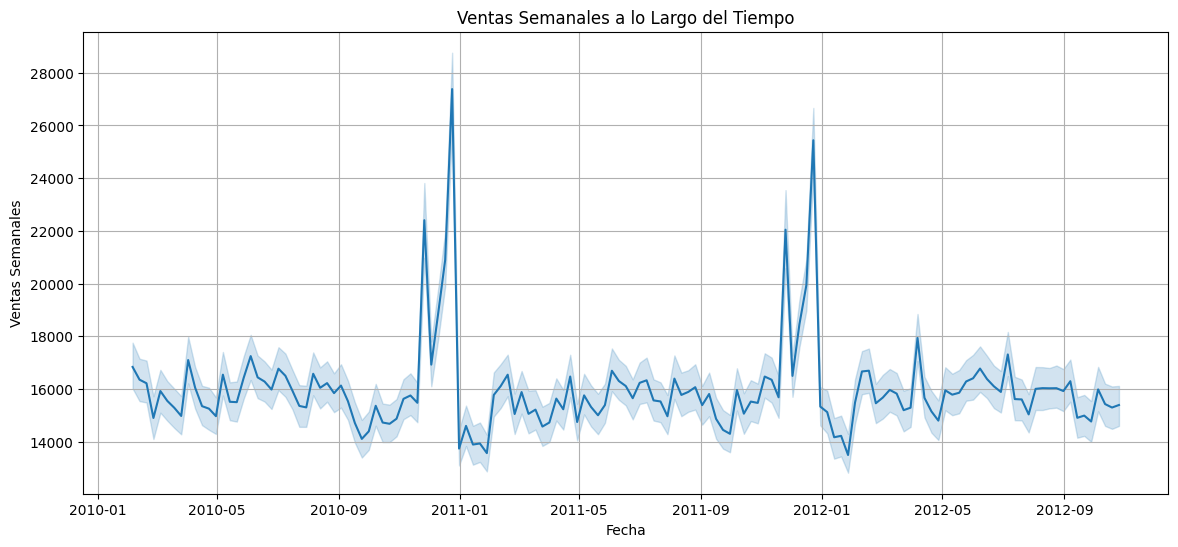

In [ ]:
graficar_ventas_por_fecha(train_df)

Se puede evidenciar que las ventas semanales tienen una tendencia aproximadamente periodica durante los aproximadamente 3 años del estudio. Teniendo un comportamiento oscilante a lo largo de los meses del año y con picos considerables de venta durante el periodo de navidad.

In [ ]:
def graficar_markdowns(df):
    # Asegurarse de que la columna 'Date' sea de tipo datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Lista de columnas de Markdown
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

    # Configurar la figura con subgráficos
    fig, axes = plt.subplots(len(markdown_cols), 1, figsize=(14, 4 * len(markdown_cols)), sharex=True)

    # Graficar cada columna de Markdown en un subgráfico
    for i, col in enumerate(markdown_cols):
        sns.lineplot(x='Date', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'Evolución de {col}')
        axes[i].set_ylabel('Valor')
        axes[i].grid(True)

    # Agregar etiqueta de fecha solo en el último gráfico
    axes[-1].set_xlabel('Fecha')

    plt.tight_layout()
    plt.show()

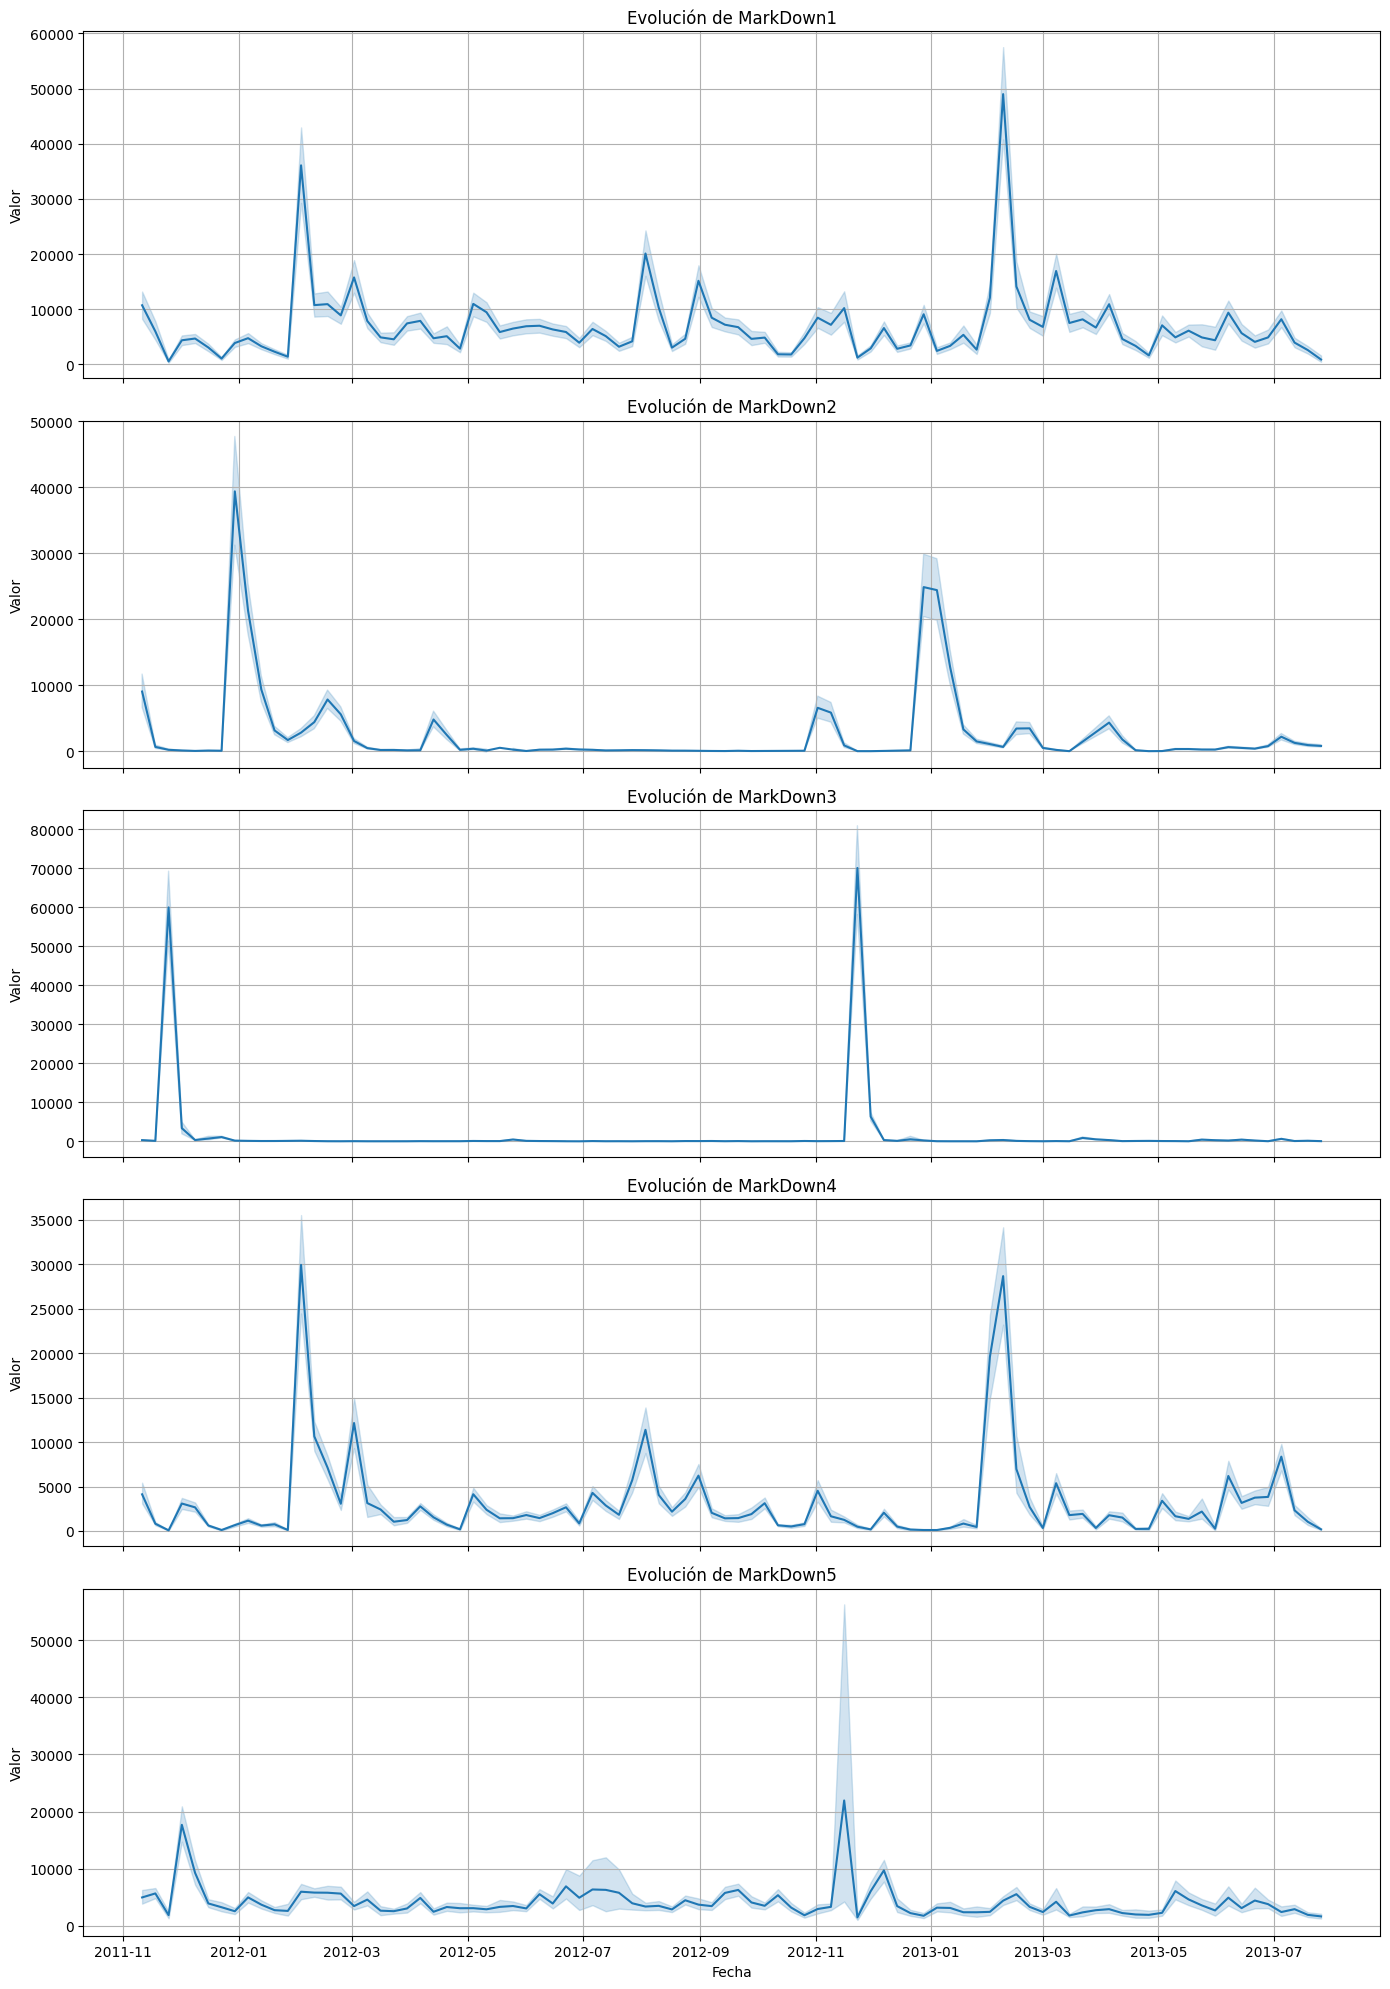

In [ ]:
graficar_markdowns(features_df)

La demanda de los productos anonimizados "Markdown" tiene un comportamiento similar al de las ventas en general. Con un comportamiento aproximadamente periodico, compra moderada a lo largo del año y picos de ventas en ciertos meses. Cabe aclarar que las graficas muestran picos de venta que en algunos casos tienen desfase respecto a las ventas generales de Wallmart. Esto puede deberse a la naturaleza propia de cada producto, motivando a los clientes a comprarlos en fechas ligeramente antes o despues de navidad.

### Correlaciones Entre Variables:

In [ ]:
def crear_pairplot(df, diag_kind='kde'):

    # Graficar el pairplot
    sns.pairplot(df, diag_kind=diag_kind, plot_kws={'alpha': 0.5})
    plt.suptitle('Pairplot del Dataset', y=1.02)
    plt.show()

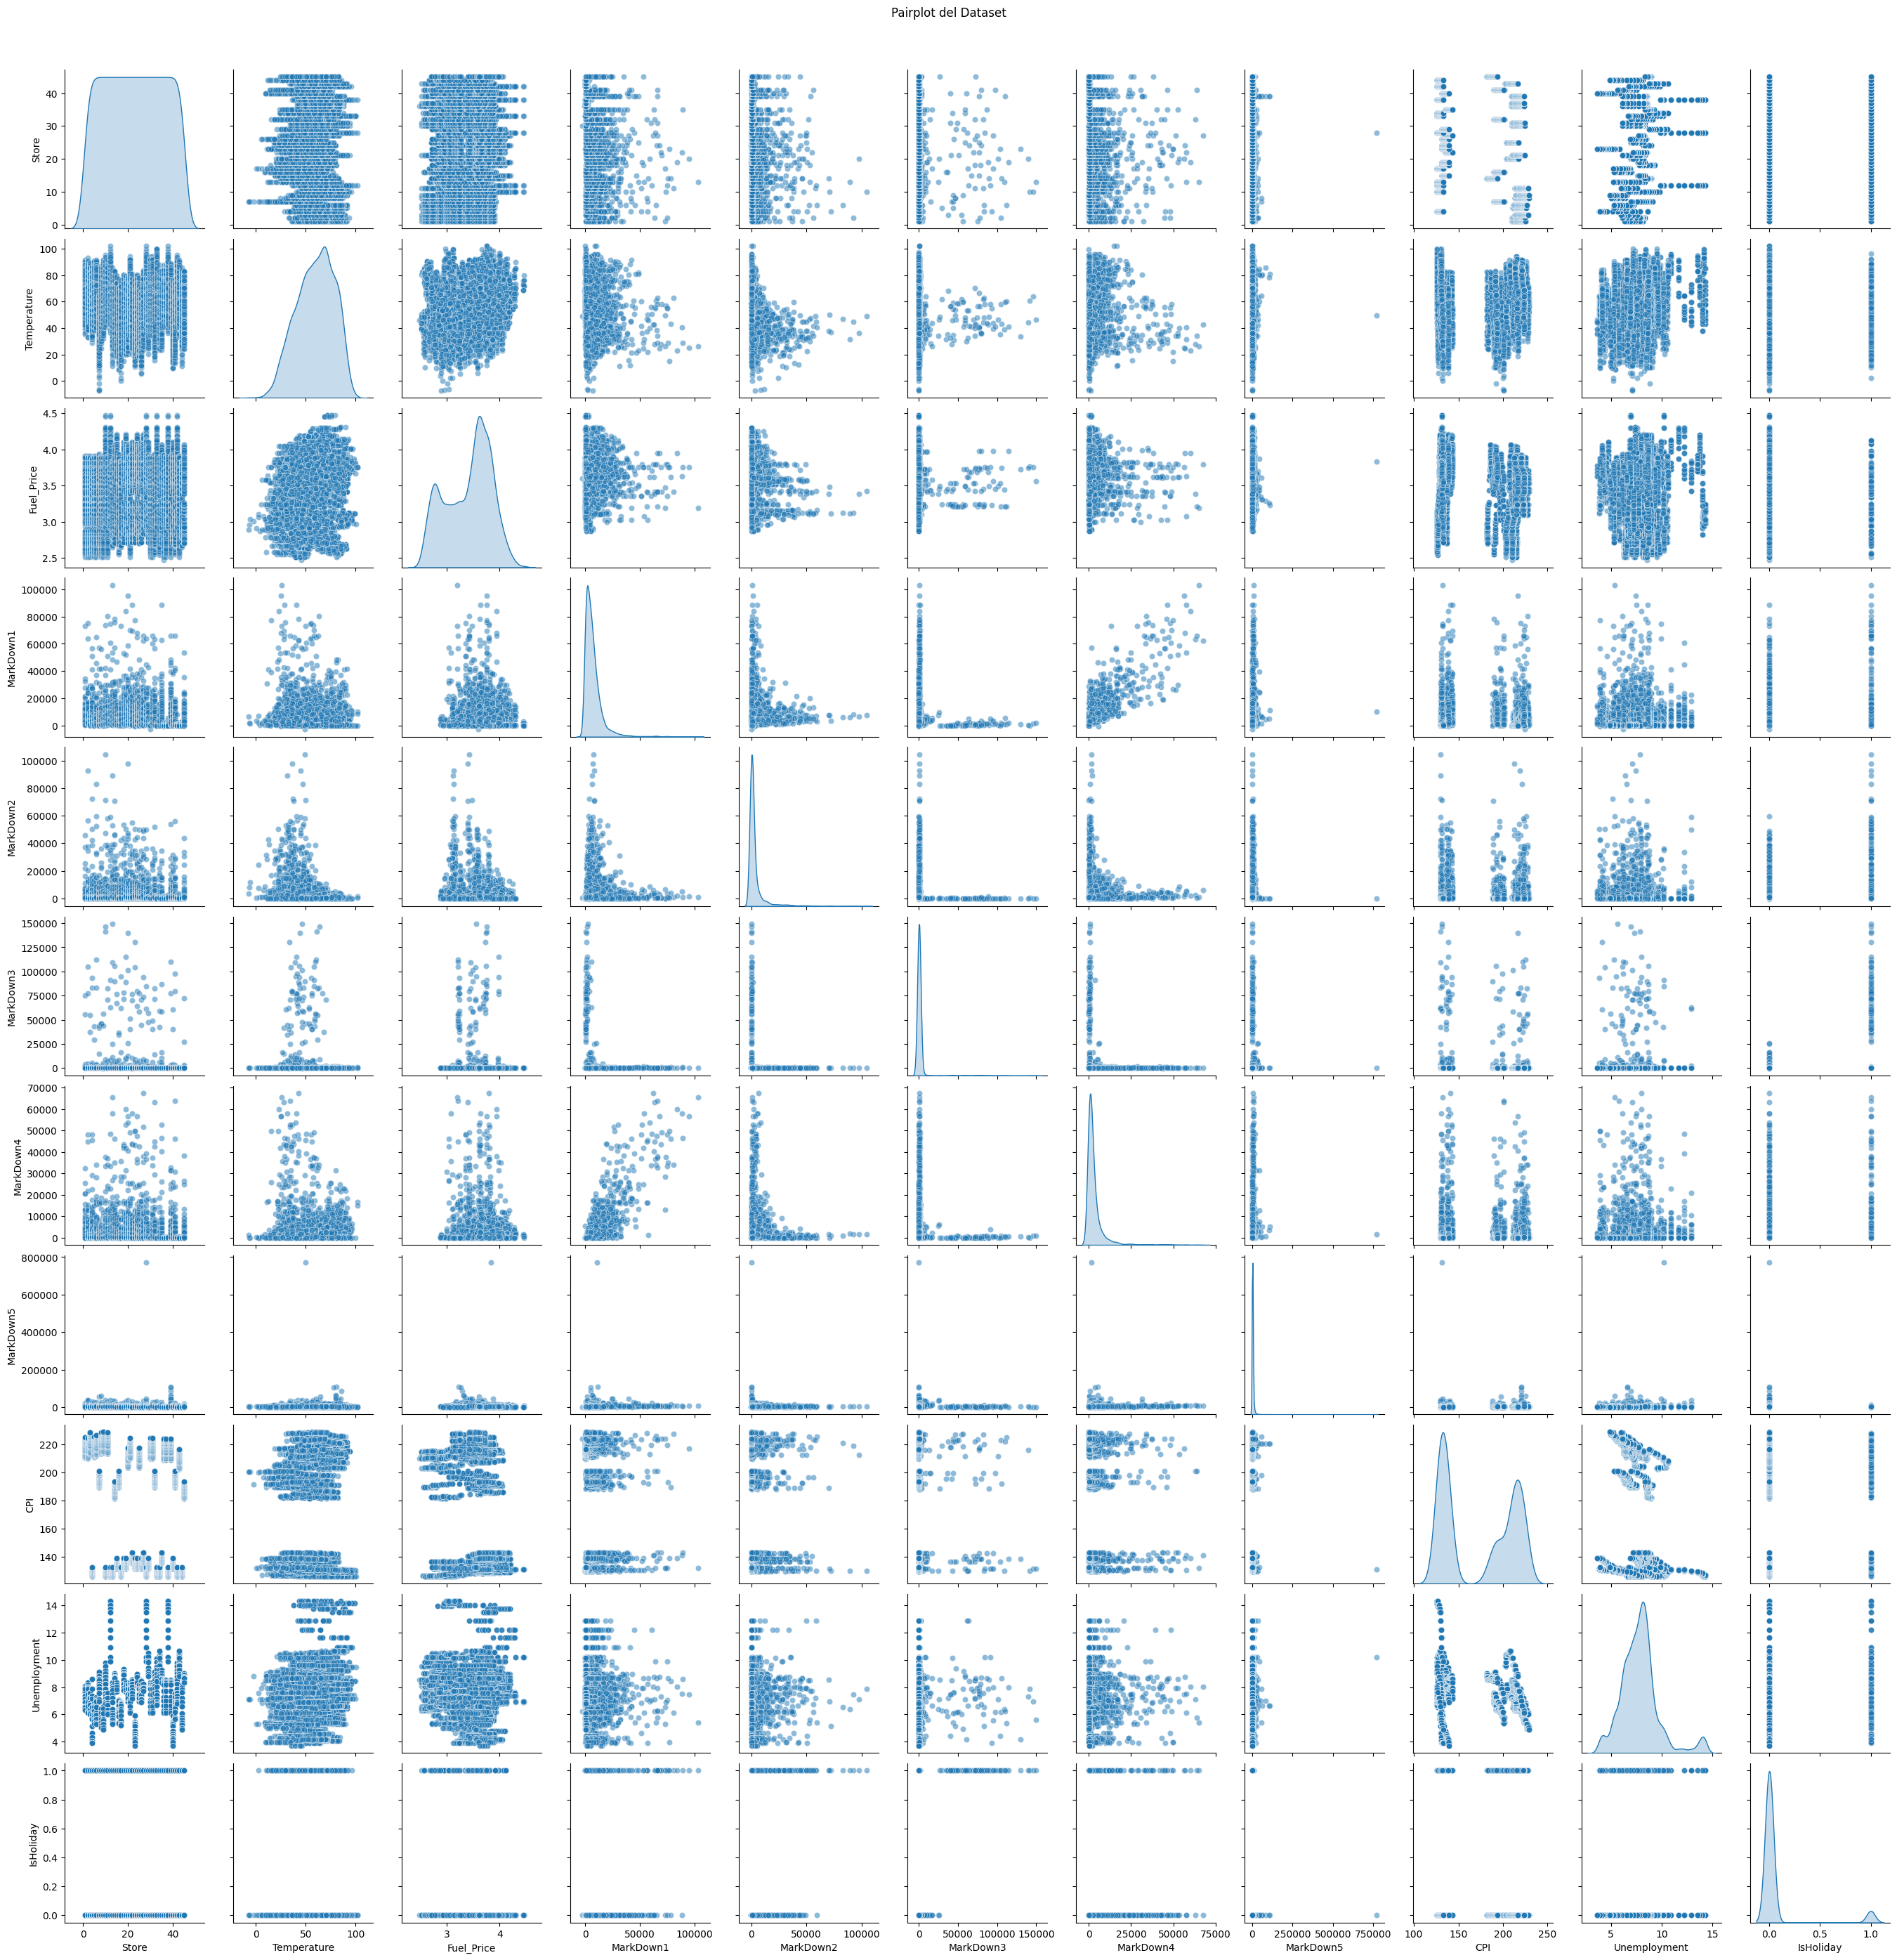

In [ ]:
crear_pairplot(features_df)

El daraset no presenta correlaciones lineales significativas entre las variables, a excepcion de los productos Markdown 4 y Markdown 1, sin embargo podemos evidenciar algunas correlaciones no lineales decrecientes que podrían resultar de interes para la construcción del modelo. A pesar de todo esto, en general no se perciben demasiadas correlaciones entre las variables.

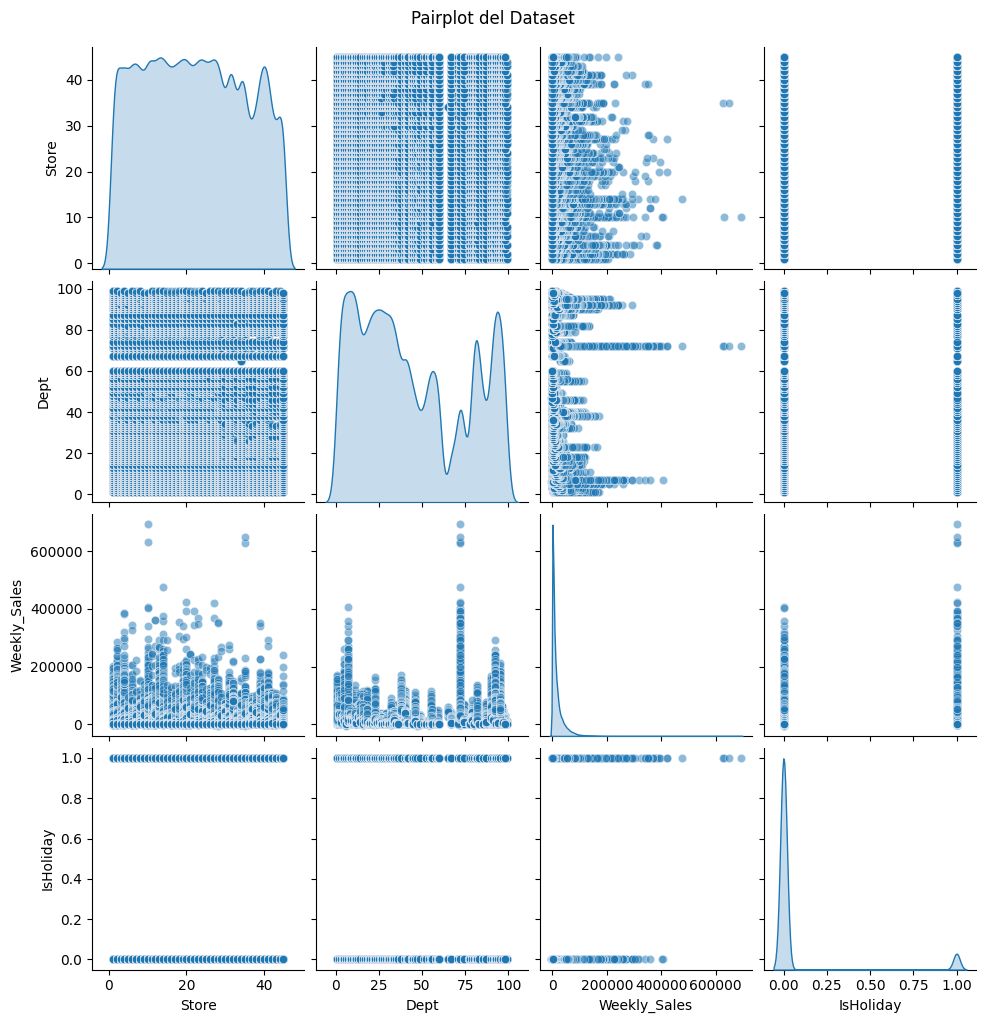

In [ ]:
crear_pairplot(train_df)

No se perciben correlaciones de interes entre las variables

In [ ]:
def graficar_matriz_correlacion(df, cols_numericas=None):

    if cols_numericas is None:
        cols_numericas = df.select_dtypes(include=['float64', 'int64']).columns

    corr_matrix = df[cols_numericas].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
    plt.title('Matriz de Correlación', fontsize=16)
    plt.show()


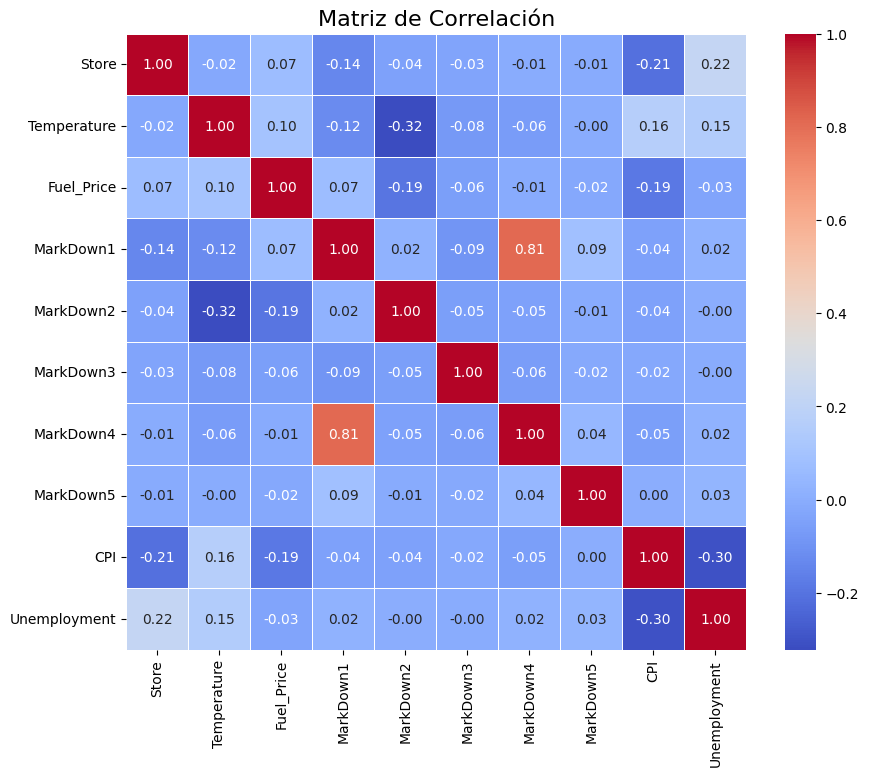

In [ ]:
graficar_matriz_correlacion(features_df)

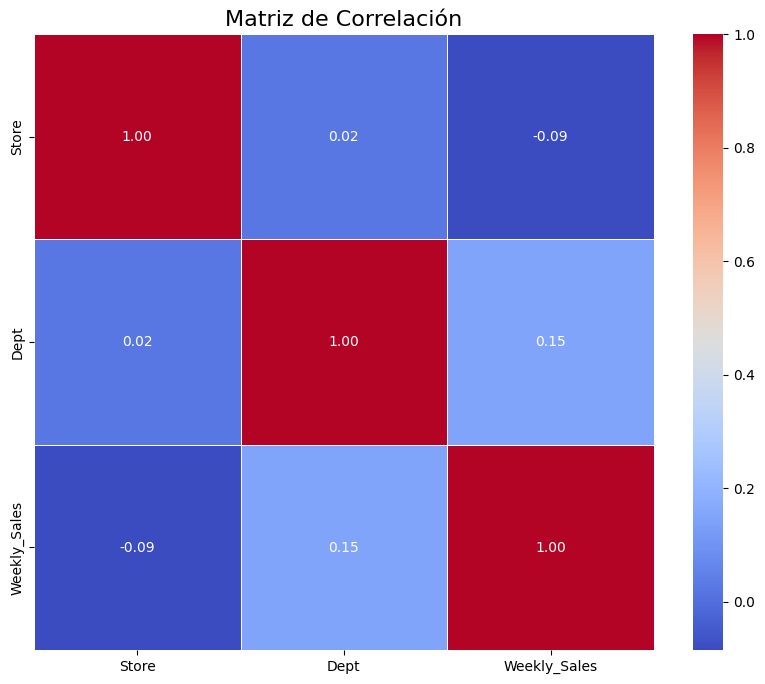

In [ ]:
graficar_matriz_correlacion(train_df)

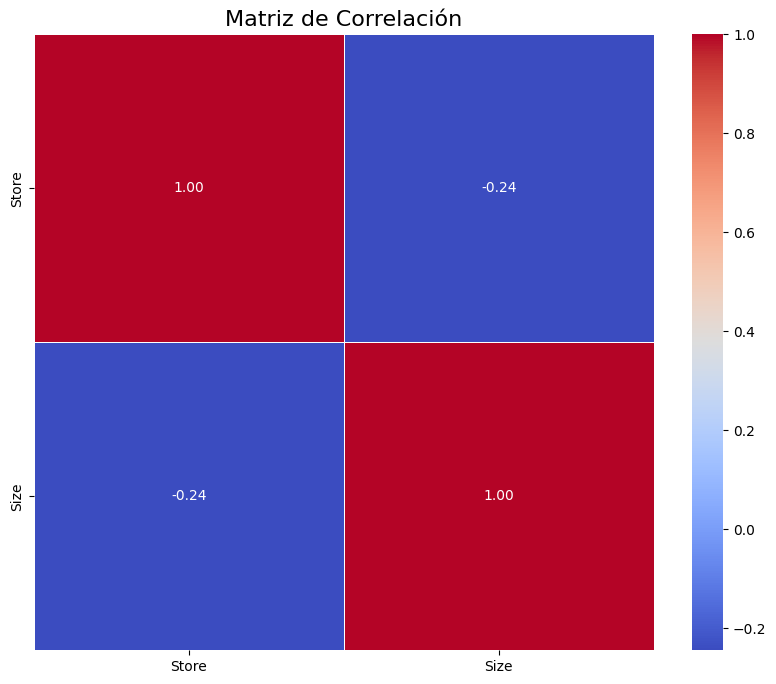

In [ ]:
graficar_matriz_correlacion(stores_df)

### Conclusiones:

Teniendo en cuenta el objetivo de nuestro estudio notamos rapidamente que el dataset train solo tiene un recuento general de las ventas de cada tienda a lo largo de las semanas del estudio. Mientras tanto el dataset features contiene información mucho mas especifica respecto a productos y otras variables de interes que podrían ser influyentes en la demanda de la empresa en cierto periodo de tiempo.

Se ha decidido empezar la aproximación del problema realizando un Merge de los dataframe para obtener la mayor cantidad de información posible para el entrenamiento de la red. Sugerimos crear unos datos de entrada que relacionen las series de tiempo de las ventas con otras variables relevantes.

## Merge De Los Dataset:

In [ ]:
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
# Rellenar los missing values en 'CPI' y 'Unemployment' de features_df con la mediana
features_df['CPI'] = features_df['CPI'].fillna(features_df['CPI'].median())
features_df['Unemployment'] = features_df['Unemployment'].fillna(features_df['Unemployment'].median())

In [ ]:
# Rellenar las columnas de MarkDown (MarkDown1 a MarkDown5) con mediana
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    features_df[col] = features_df[col].fillna(features_df[col].median())

In [ ]:
# Asegurarse de que la columna 'Store' tenga el mismo formato en todos los dataframes:
# Convertir la columna 'Store' a string y eliminar espacios en blanco

features_df['Store'] = features_df['Store'].astype(str).str.strip()
train_df['Store'] = train_df['Store'].astype(str).str.strip()
stores_df['Store'] = stores_df['Store'].astype(str).str.strip()
test_df['Store'] = test_df['Store'].astype(str).str.strip()

In [ ]:
# Convertir las columnas de fecha a datetime en los dataframes correspondientes

features_df['Date'] = pd.to_datetime(features_df['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [ ]:
# Fusionar los dataframes:

# Unir features_df con train_df en las columnas 'Store' y 'Date'
merged_df = pd.merge(features_df, train_df, on=['Store', 'Date'], how='inner')

# Unir el resultado con stores_df usando la columna 'Store'
final_merged_df = pd.merge(merged_df, stores_df, on='Store', how='inner')

# Hacer drop de la columna IsHoliday_y y renombrar IsHoliday_x
final_merged_df = final_merged_df.drop(columns=['IsHoliday_y']).rename(columns={'IsHoliday_x': 'IsHoliday'})

# Convertir IsHoliday a binario 0, 1
final_merged_df['IsHoliday'] = final_merged_df['IsHoliday'].astype(int)

In [ ]:
info_basica(final_merged_df)

Dimensiones: (421570, 16)

Columnas: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Type', 'Size']

Nulos por columna:
 Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
Dept            0
Weekly_Sales    0
Type            0
Size            0
dtype: int64

Valores únicos por columna:
 Store               45
Date               143
Temperature       3528
Fuel_Price         892
MarkDown1         2278
MarkDown2         1499
MarkDown3         1662
MarkDown4         1945
MarkDown5         2294
CPI               2145
Unemployment       349
IsHoliday            2
Dept                81
Weekly_Sales    359464
Type                 3
Size                40
dtype: int64

Primeras 5 filas:
   Store       Date  Te

### Estadistica Descriptiva Especifica:

<ipython-input-12-f5b267c619e7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=store_sales.index, y=store_sales.values, palette="viridis")


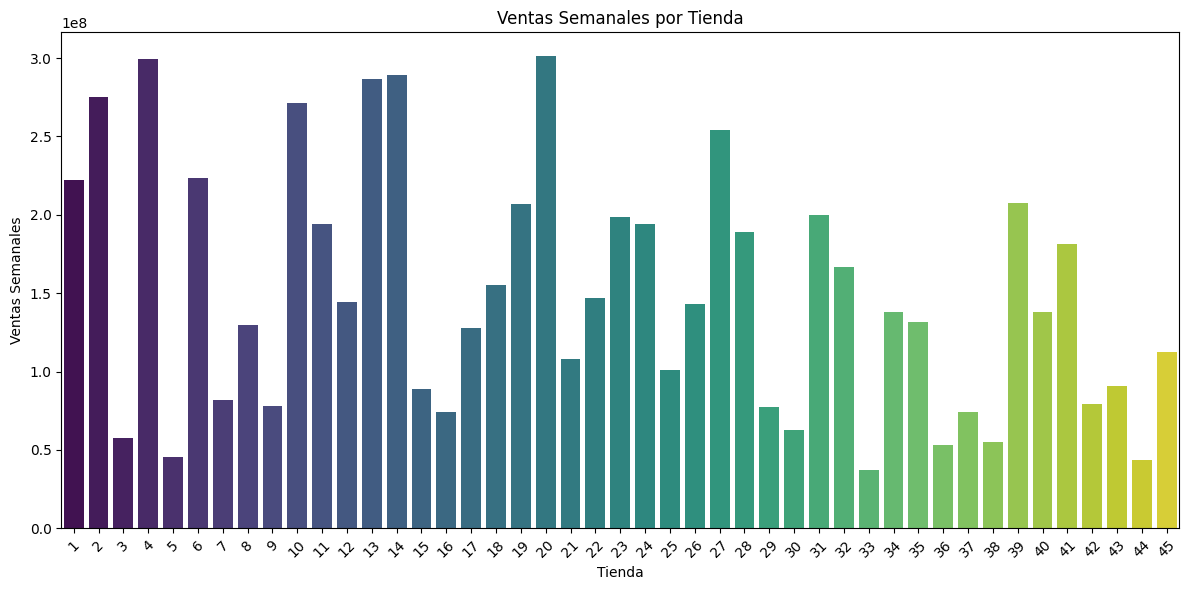

In [ ]:
# Graficar las ventas semanales por tienda

store_sales = final_merged_df.groupby('Store')['Weekly_Sales'].sum()
store_sales.index.name = 'Store'
store_sales.index = store_sales.index.astype(int)
store_sales = store_sales.sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=store_sales.index, y=store_sales.values, palette="viridis")

plt.title('Ventas Semanales por Tienda')
plt.xlabel('Tienda')
plt.ylabel('Ventas Semanales')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
def normalize_series(series):

    min_val = series.min()
    max_val = series.max()
    if max_val - min_val == 0:
        return series * 0  # O alternativamente, se puede devolver series, según se prefiera
    return (series - min_val) / (max_val - min_val)


def plot_indicators_over_time(df, column_names):

    # Asegurarse de que la columna 'Date' sea de tipo datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Agrupar por fecha y calcular el promedio de las columnas especificadas
    df_grouped = df.groupby('Date')[column_names].mean().reset_index()

    # Calcular la sumatoria de las ventas semanales
    df_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

    # Merge para tener ambos en el mismo DataFrame
    df_merged = pd.merge(df_grouped, df_sales, on='Date')

    # Normalizar cada una de las columnas en column_names y Weekly_Sales
    for col in column_names + ['Weekly_Sales']:
        df_merged[col] = normalize_series(df_merged[col])

    # Graficar todas las series en una misma figura
    plt.figure(figsize=(12, 6))
    for col in column_names:
        plt.plot(df_merged['Date'], df_merged[col], marker='.', label=col)

    # Graficar la sumatoria de las ventas semanales con estilo distinto
    plt.plot(df_merged['Date'], df_merged['Weekly_Sales'], linestyle='--', label='Weekly_Sales (Sum)')

    plt.title('Tendencias normalizadas a lo largo del tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Valor normalizado')
    plt.legend()
    plt.grid(True)
    plt.show()

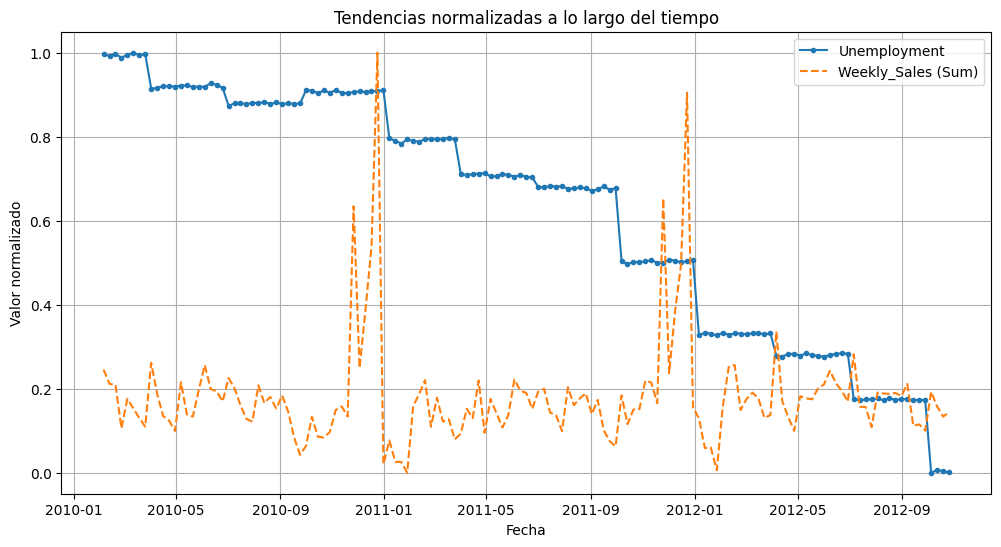

In [ ]:
plot_indicators_over_time(final_merged_df, ['Unemployment'])

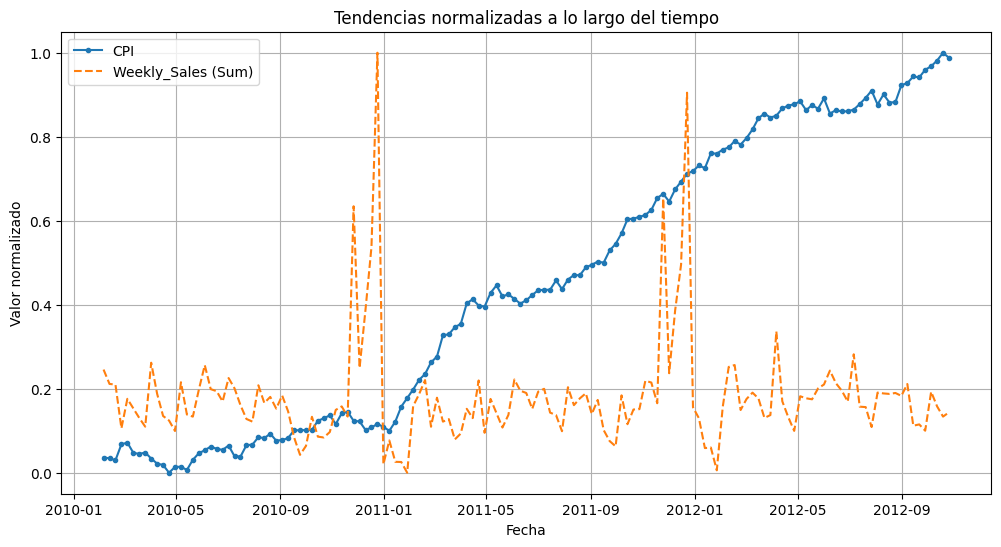

In [ ]:
plot_indicators_over_time(final_merged_df, ['CPI'])

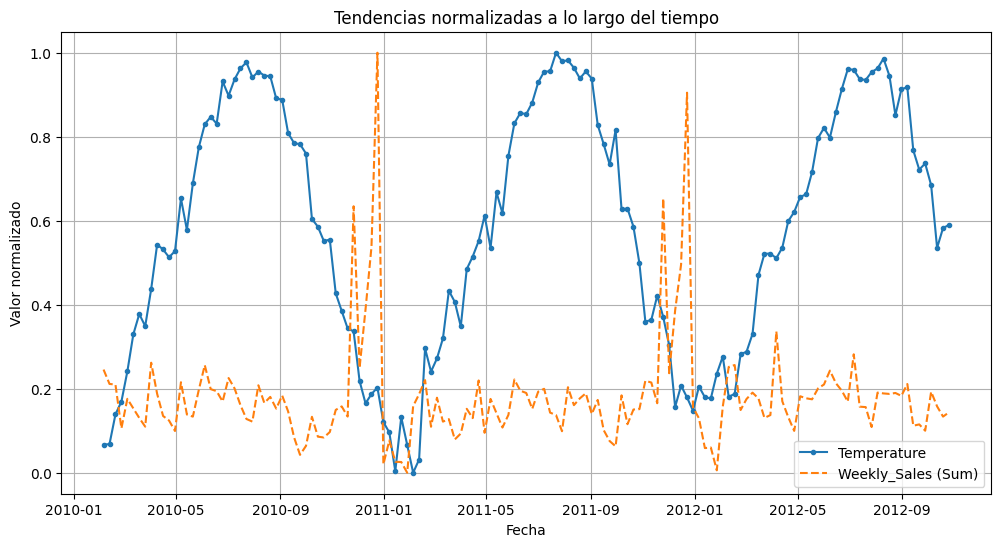

In [ ]:
plot_indicators_over_time(final_merged_df, ['Temperature'])

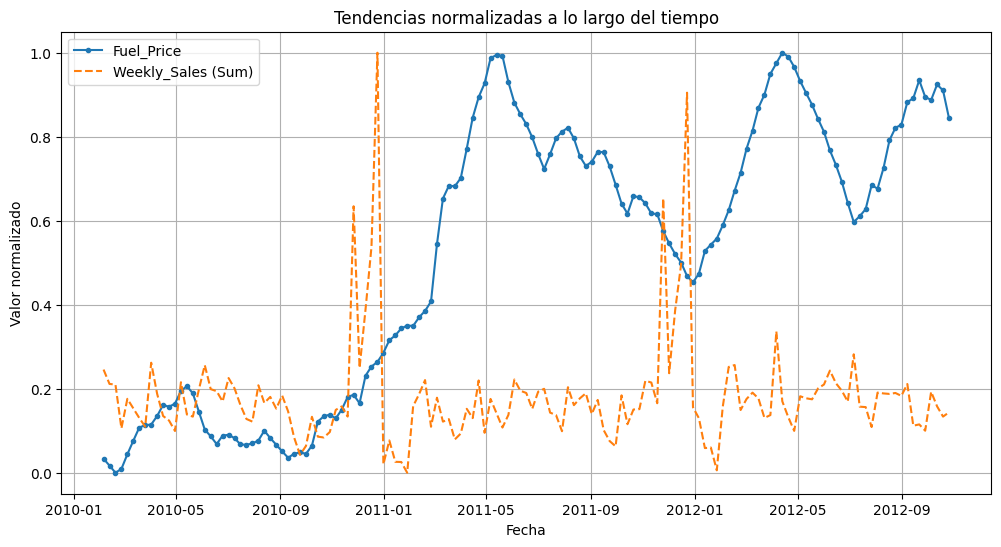

In [ ]:
plot_indicators_over_time(final_merged_df, ['Fuel_Price'])

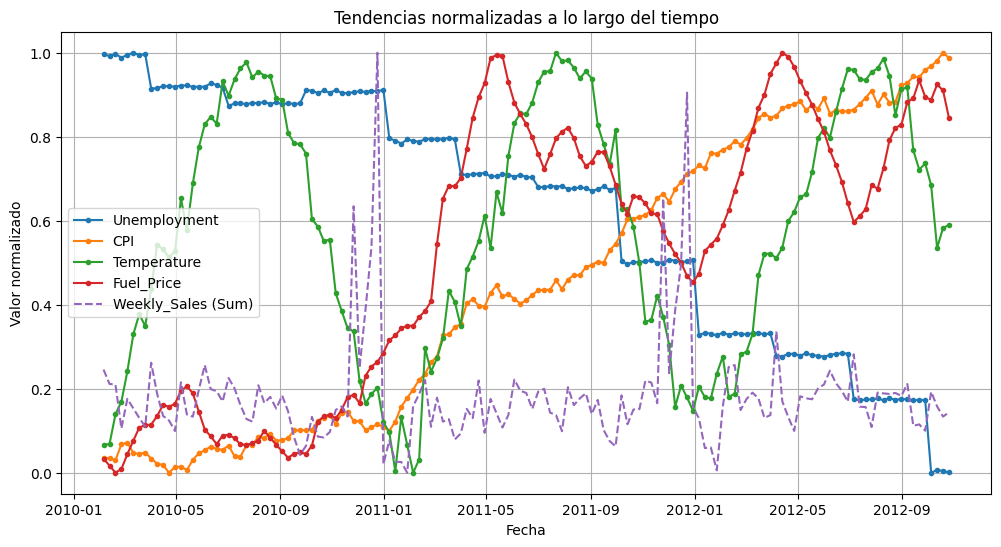

In [ ]:
plot_indicators_over_time(final_merged_df, ['Unemployment', 'CPI', 'Temperature', 'Fuel_Price'])

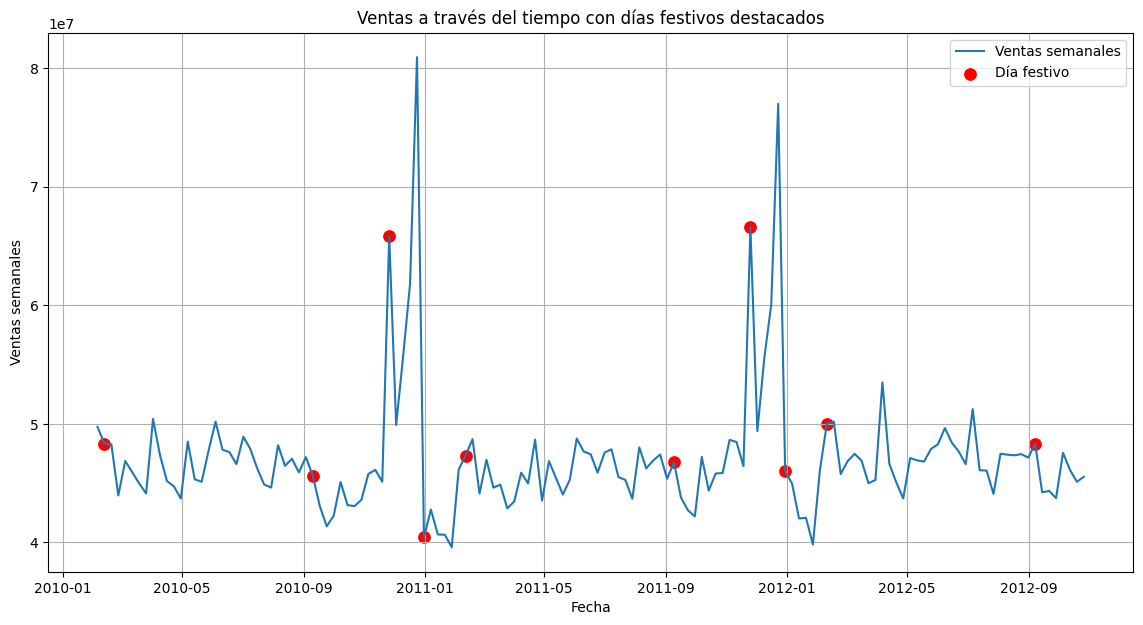

In [ ]:
sales_holidays_df = final_merged_df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'IsHoliday': 'max'
}).reset_index()

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar la línea de ventas a lo largo del tiempo
sns.lineplot(data=sales_holidays_df, x='Date', y='Weekly_Sales', label='Ventas semanales')

# Filtrar las fechas festivas y graficarlas como puntos rojos
holidays = sales_holidays_df[sales_holidays_df['IsHoliday'] == 1]
sns.scatterplot(data=holidays, x='Date', y='Weekly_Sales', color='red', s=100, label='Día festivo')

# Personalizar el gráfico
plt.title('Ventas a través del tiempo con días festivos destacados')
plt.xlabel('Fecha')
plt.ylabel('Ventas semanales')
plt.legend()
plt.grid(True)
plt.show()

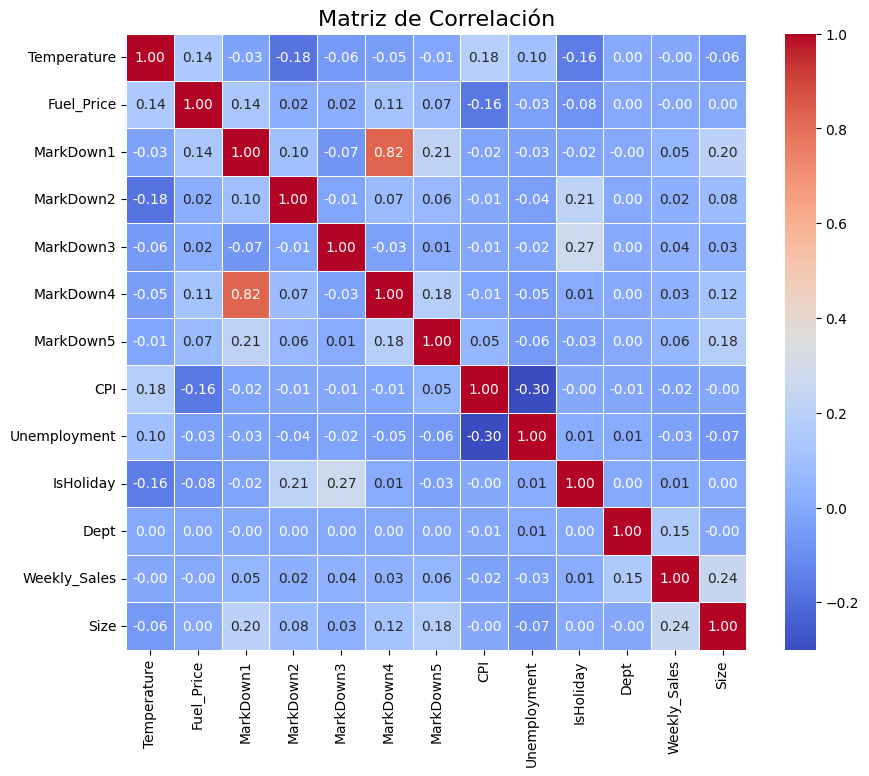

In [ ]:
# Matriz de correlacion de variables
graficar_matriz_correlacion(final_merged_df)

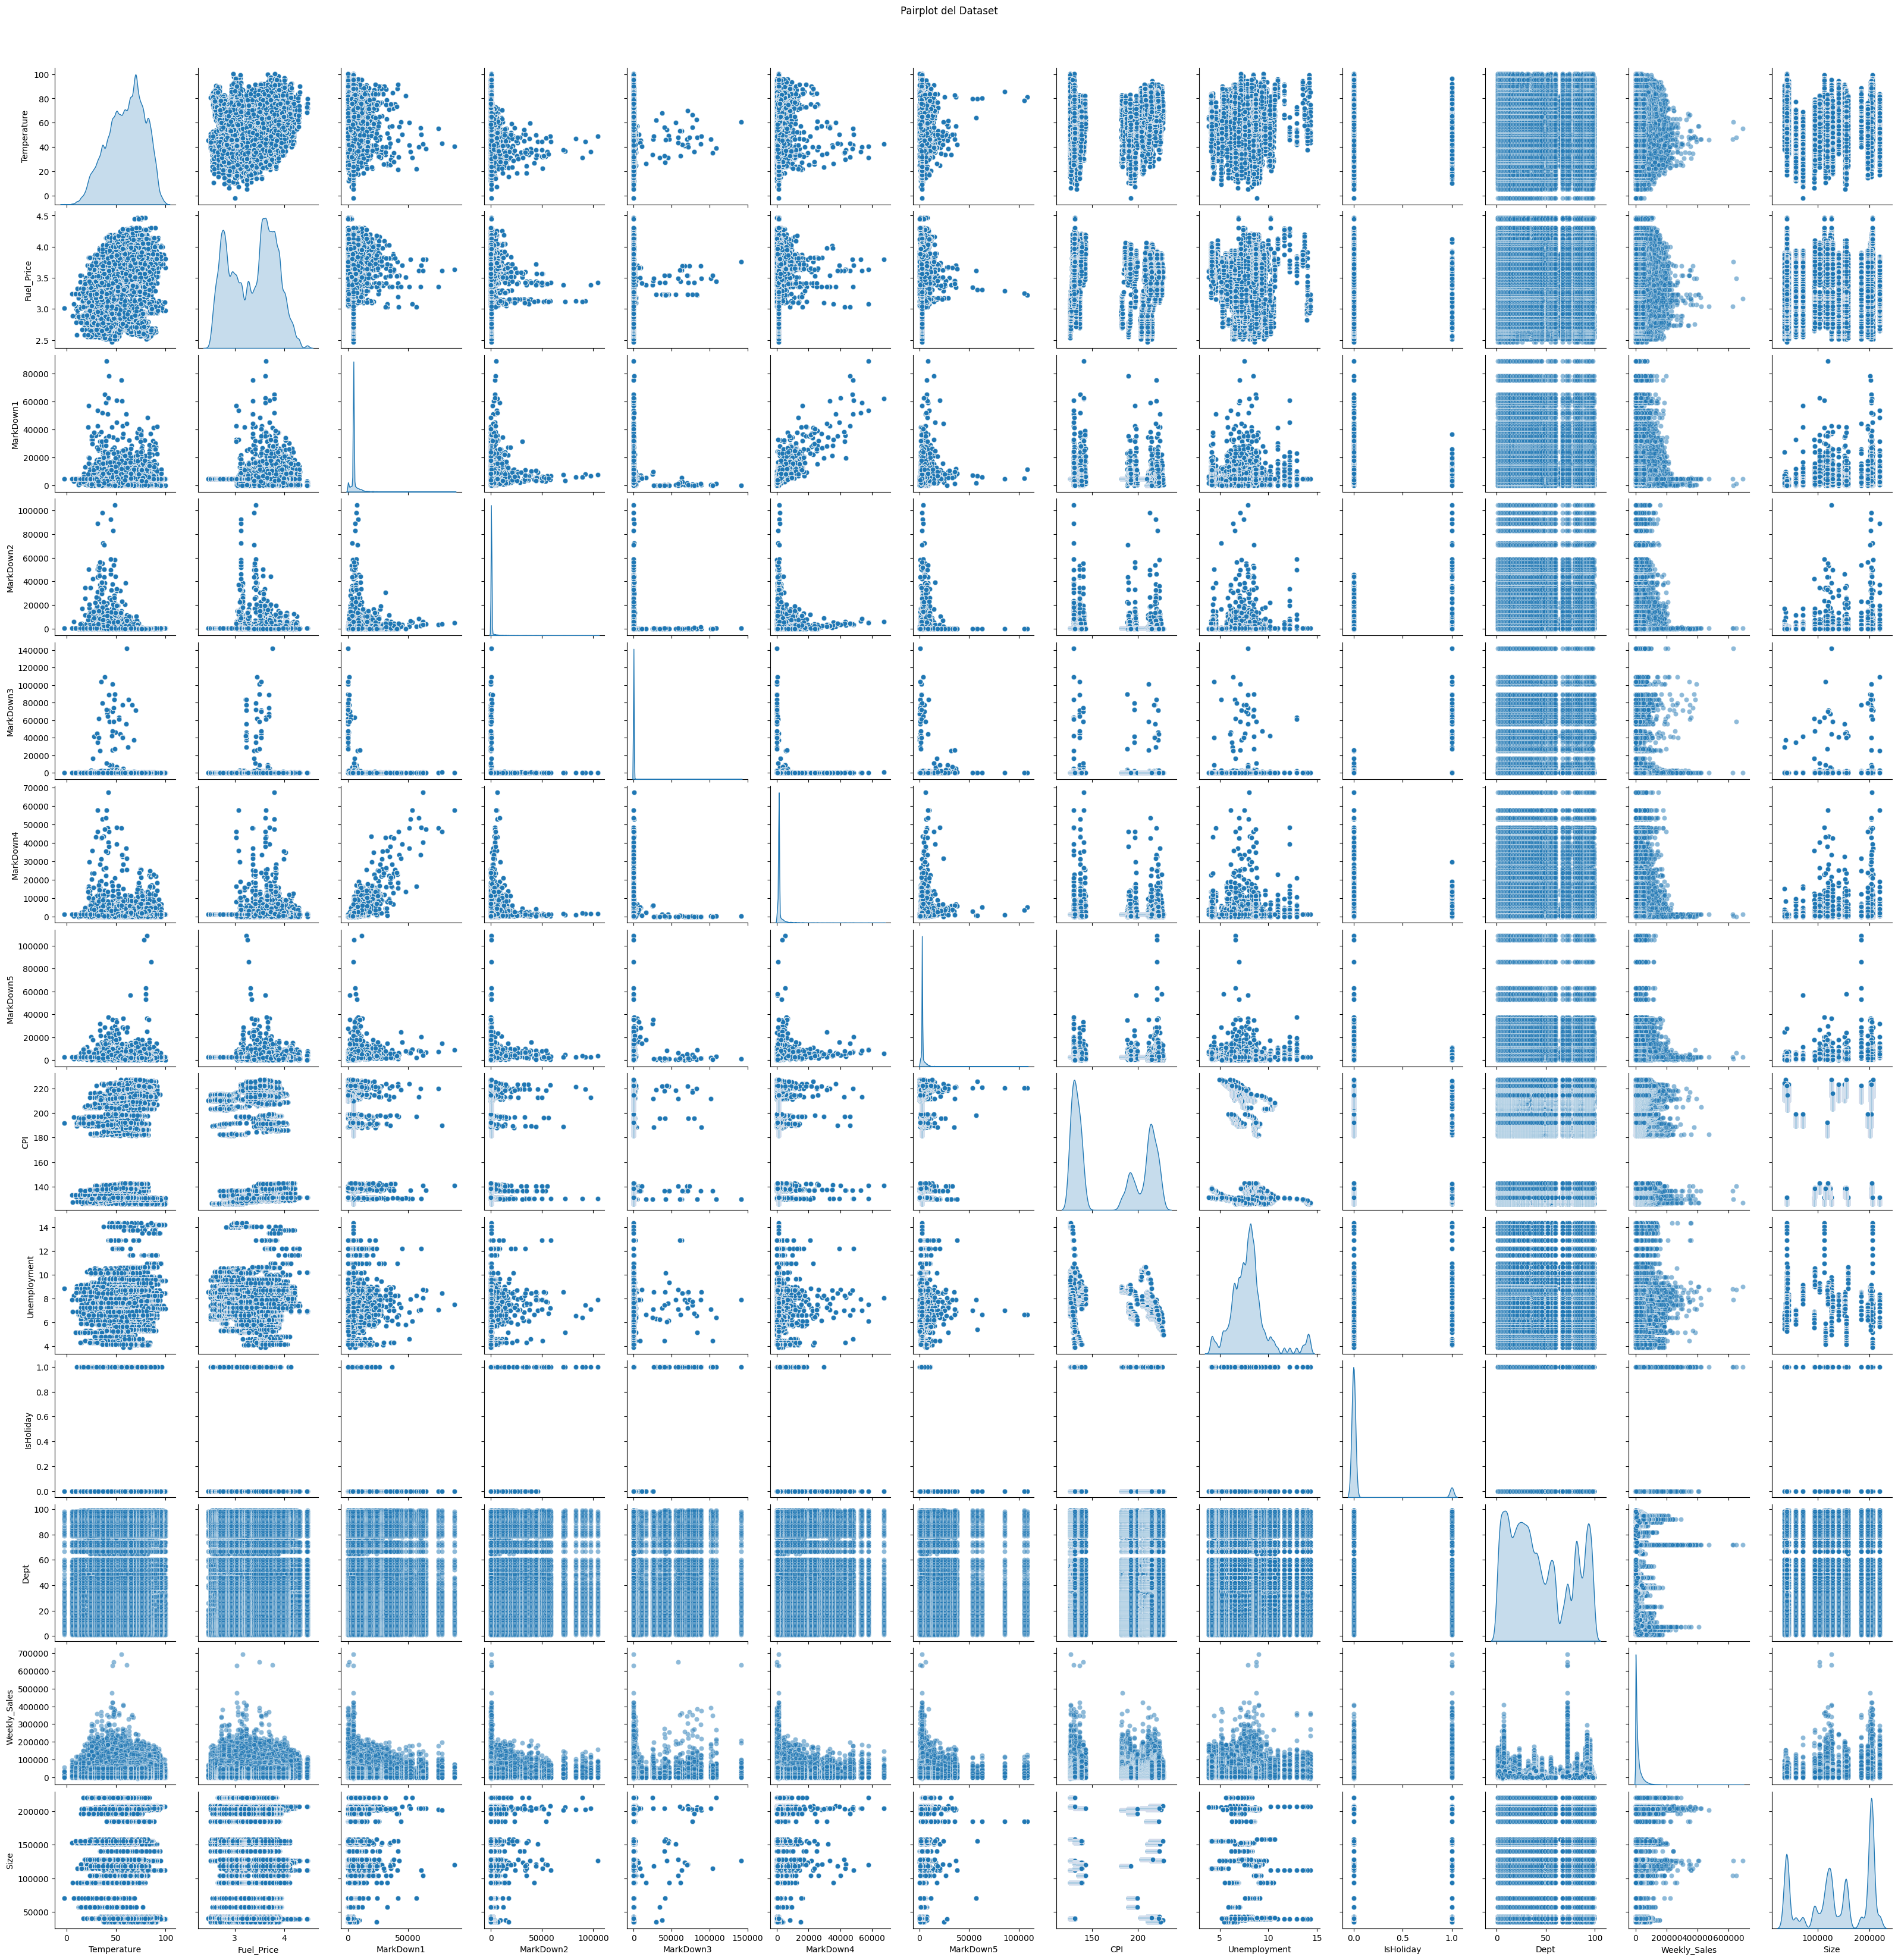

In [ ]:
# Crear Pairplot
crear_pairplot(final_merged_df)

Segun los analisis realizados el equipo ha determinado que a traves del tiempo, los datos no han mostrado correlaciones significativas entre algunos de los indicadores presentes tales como:

*   Unemployment
*   CPI
*   Fuel_Price

Con la variable objetivo Weekly Sales.

Sin embargo se ha detectado que las variables

*   Temperature
*   IsHoliday

Ayudan a predecir periodos del año donde hay incrementos y decrementos significativos en las Weekly Sales, por tal motivo se ha decidido entrenar el modelo de redes neuronales LSTM requerido tanto con entradas de series de tiempo como con entradas de los datos de las variables anteriormente mencionadas.



In [ ]:
# Agrupar por fecha aplicando funciones de agregación
df_grouped = final_merged_df.groupby('Date').agg({
    'Weekly_Sales': 'sum',    # Suma de ventas por fecha
    'Temperature': 'mean',    # Promedio de la temperatura
    'IsHoliday': 'max'        # Máximo indicador de día festivo
}).reset_index()


# Definir el periodo para la descomposición: 52 semanas
periodo = 52


def plot_decomposition(series, title, period):

    decomp = seasonal_decompose(series, model='additive', period=period)
    fig = decomp.plot()
    fig.set_size_inches(10, 8)
    fig.suptitle(title, fontsize=16)

    for ax in fig.get_axes():

        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

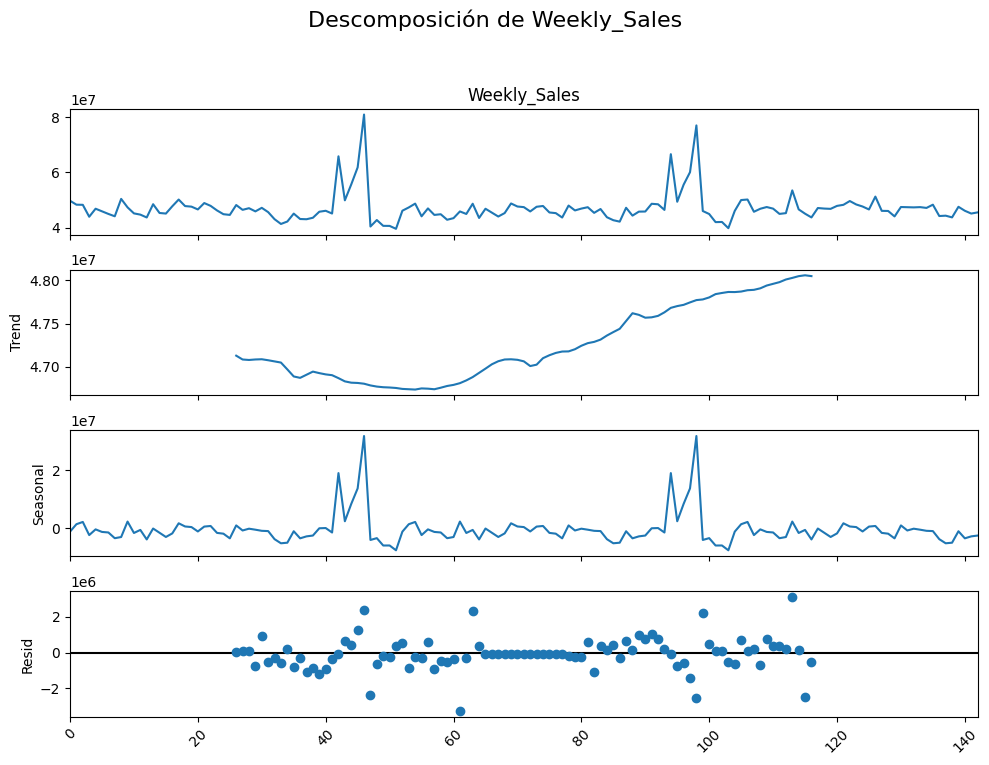

In [ ]:
# Descomponer y graficar Weekly_Sales
plot_decomposition(df_grouped['Weekly_Sales'], 'Descomposición de Weekly_Sales', periodo)

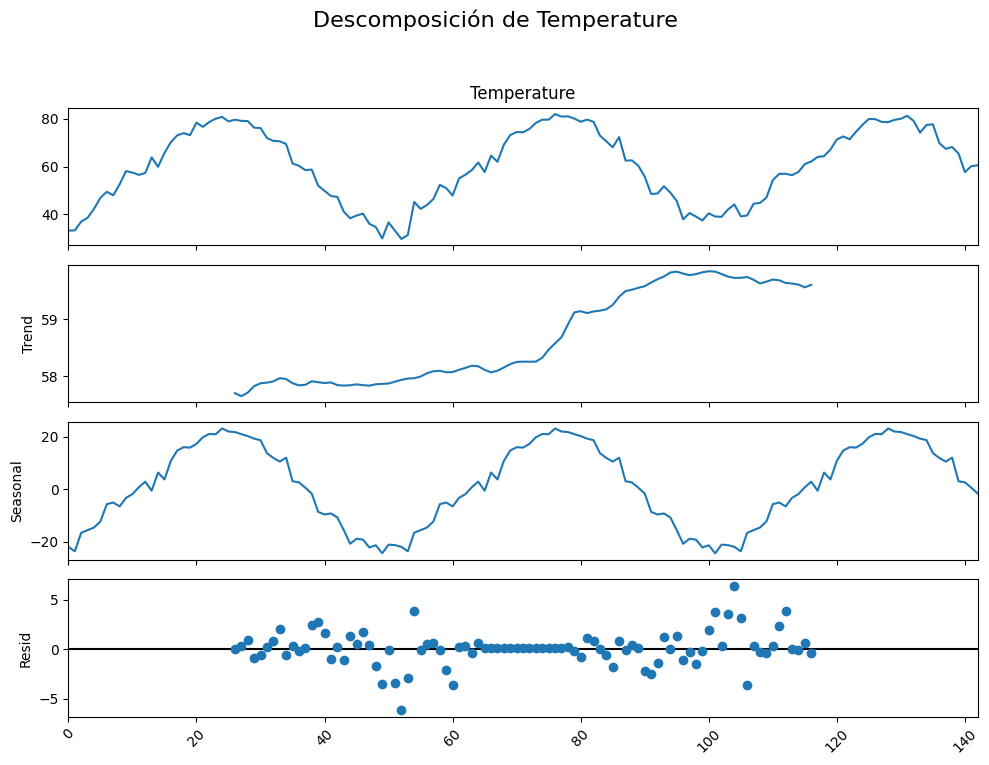

In [ ]:
plot_decomposition(df_grouped['Temperature'], 'Descomposición de Temperature', periodo)

# Modelo

## Preprocesamiento De Datos

In [ ]:
# Normalización de 'Weekly_Sales' y 'Temperature' usando MinMaxScaler
scaler_sales = MinMaxScaler()
scaler_temp  = MinMaxScaler()

df_grouped['Weekly_Sales_scaled'] = scaler_sales.fit_transform(df_grouped[['Weekly_Sales']])
df_grouped['Temperature_scaled']  = scaler_temp.fit_transform(df_grouped[['Temperature']])
df_grouped['IsHoliday'] = df_grouped['IsHoliday'].astype(float)

joblib.dump(scaler_sales, 'scaler_sales.pkl')
joblib.dump(scaler_temp,  'scaler_temp.pkl')

# Para la creación de secuencias usaremos las columnas escaladas:
# 'Weekly_Sales_scaled', 'Temperature_scaled' e 'IsHoliday'
data_scaled = df_grouped[['Weekly_Sales_scaled', 'Temperature_scaled', 'IsHoliday']]

In [ ]:
# Creación de secuencias temporales
# Cada secuencia tendrá una longitud definida por window_size (por defecto 8 semanas).
# La etiqueta (y) será el valor de Weekly_Sales_scaled de la semana siguiente a cada ventana.

# Parámetros
future_steps = 104
window_size = 8

# Normalización de las variables
scaler_sales = MinMaxScaler()
scaler_temp = MinMaxScaler()

# Normalizar ventas y temperatura
df_grouped['Weekly_Sales_Scaled'] = scaler_sales.fit_transform(df_grouped[['Weekly_Sales']])
df_grouped['Temperature_Scaled'] = scaler_temp.fit_transform(df_grouped[['Temperature']])

# Preparar los datos para LSTM
data_scaled = df_grouped[['Weekly_Sales_Scaled', 'Temperature_Scaled', 'IsHoliday']].values

X = []
y = []

for i in range(window_size, len(data_scaled)):
    X.append(data_scaled[i - window_size:i])
    y.append(data_scaled[i, 0])  # Predicción de ventas

X, y = np.array(X), np.array(y)

last_window = data_scaled[-window_size:]
np.save('last_window.npy', last_window)

In [ ]:
print(last_window)

[[0.21122372 0.9179487  1.        ]
 [0.11192864 0.76763922 0.        ]
 [0.11503785 0.72174669 0.        ]
 [0.10004573 0.73626675 0.        ]
 [0.19275309 0.68451963 0.        ]
 [0.15795825 0.53533285 0.        ]
 [0.13361599 0.58267367 0.        ]
 [0.14381898 0.58992265 0.        ]]


## Entrenamiento

In [ ]:
def save_model(model, filename='trained_model.h5'):
    model.save(filename)
    print("Modelo guardado en", filename)

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=1e-5)

In [ ]:
history = model.fit(X,
                    y,
                    epochs=100,
                    batch_size=1,
                    verbose=2,
                    callbacks=[early_stopping, reduce_lr])


save_model(model, 'trained_model.h5')

Epoch 1/100
135/135 - 7s - 54ms/step - loss: 0.0223 - learning_rate: 0.0010
Epoch 2/100
135/135 - 3s - 23ms/step - loss: 0.0209 - learning_rate: 0.0010
Epoch 3/100
135/135 - 2s - 12ms/step - loss: 0.0195 - learning_rate: 0.0010
Epoch 4/100
135/135 - 2s - 16ms/step - loss: 0.0193 - learning_rate: 0.0010
Epoch 5/100
135/135 - 1s - 8ms/step - loss: 0.0197 - learning_rate: 0.0010
Epoch 6/100
135/135 - 1s - 8ms/step - loss: 0.0197 - learning_rate: 0.0010
Epoch 7/100
135/135 - 2s - 14ms/step - loss: 0.0197 - learning_rate: 0.0010
Epoch 8/100
135/135 - 1s - 9ms/step - loss: 0.0184 - learning_rate: 0.0010
Epoch 9/100
135/135 - 1s - 8ms/step - loss: 0.0199 - learning_rate: 0.0010
Epoch 10/100
135/135 - 2s - 11ms/step - loss: 0.0186 - learning_rate: 0.0010
Epoch 11/100
135/135 - 2s - 14ms/step - loss: 0.0188 - learning_rate: 0.0010
Epoch 12/100
135/135 - 1s - 8ms/step - loss: 0.0189 - learning_rate: 0.0010
Epoch 13/100
135/135 - 1s - 8ms/step - loss: 0.0185 - learning_rate: 0.0010
Epoch 14/100
1

Modelo guardado en trained_model.h5


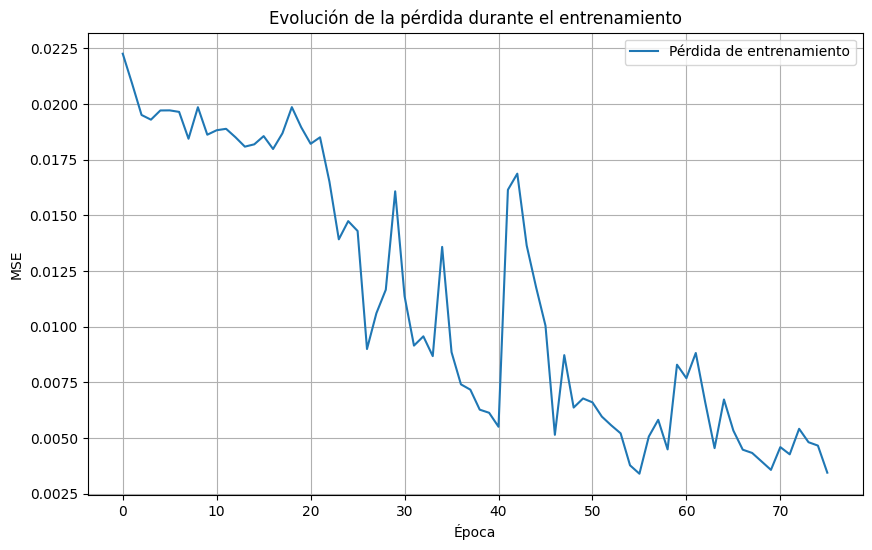

In [ ]:
# Graficar la pérdida (MSE) a lo largo de las épocas

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## Evaluación

In [ ]:
# Evaluación del modelo con los datos del estudio
forecast = []
current_batch = np.array(data_scaled[:window_size]).reshape((1, window_size, 3))  # Incluye IsHoliday

for i in range(len(data_scaled) - window_size):
    pred = model.predict(current_batch, verbose=0)[0, 0]
    forecast.append(pred)
    if window_size + i < len(data_scaled):
        next_input = np.append(current_batch[:, 1:, :], [[[pred, data_scaled[window_size + i, 1], data_scaled[window_size + i, 2]]]], axis=1)
        current_batch = next_input

# Invertir el escalado para obtener las ventas originales
forecast_sales = scaler_sales.inverse_transform(np.array(forecast).reshape(-1, 1))



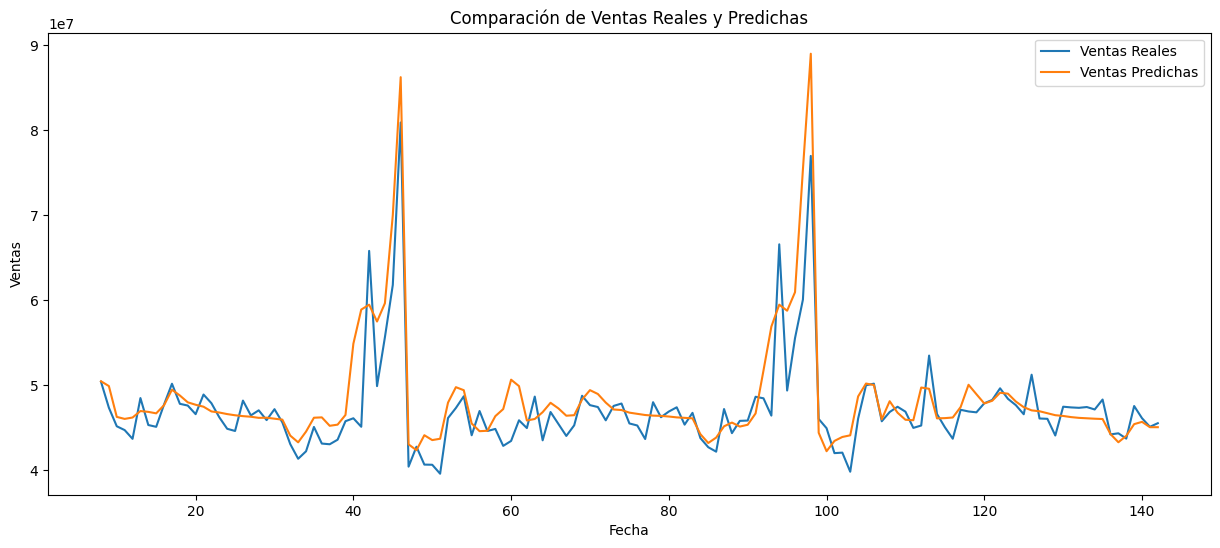

In [ ]:
# Graficar ventas reales vs predichas
plt.figure(figsize=(15, 6))
plt.plot(df_grouped.index[window_size:], df_grouped['Weekly_Sales'].values[window_size:], label='Ventas Reales')
plt.plot(df_grouped.index[window_size:], forecast_sales, label='Ventas Predichas')
plt.title('Comparación de Ventas Reales y Predichas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()